In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
import os 


### Functions

## Block 1

In [2]:
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2022-12-02_11-01-23_Riesling_lip_e1_r1_sp.h5"
bhvpath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2022-12-02_11-01-23_Riesling_e1_r1_bhv.h5"
s_path = os.path.normpath(filepath).split(os.sep)
data = SpikeData.from_python_hdf5(filepath)
bhv = BhvData.from_python_hdf5(bhvpath)

In [3]:
# Select trials and create task frame
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=bhv.condition[trial_idx],
    test_stimuli=bhv.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
cgroup = 'good'
if cgroup == 'all':
    neurons = np.where(data.clustersgroup != cgroup)[0]
else:
    neurons = np.where(data.clustersgroup == cgroup)[0]
print("Number of clusters: %d" % len(data.clustersgroup))
print("Number of %s units: %d" % (cgroup, len(neurons)))

Number of clusters: 18
Number of good units: 14


In [4]:
trial_idx[task[(task['sample']=='o1_c1')&(task['in_out']=='in')&(task['i_neuron']==0)]['trial_idx'].values]

array([ 141,  152,  183,  188,  256,  264,  278,  330,  337,  393,  399,
        430,  437,  442,  444,  454,  464,  468,  480,  518,  531,  578,
        581,  597,  639,  654,  709,  722,  735,  739,  745,  752,  776,
        795,  805,  832,  869,  882,  914,  925,  948,  964,  967, 1020,
       1069, 1077, 1103, 1116, 1117, 1136, 1138, 1189, 1206, 1237, 1257,
       1310, 1383, 1415, 1455, 1498])

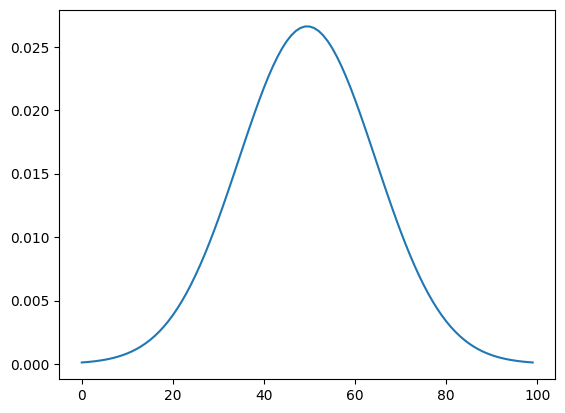

In [5]:
# define kernel for convolution
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
plt.plot(kernel)

In [6]:
# select the trials
trials_sp = data.sp_samples[trial_idx]
trials_s_on = data.code_samples[
    trial_idx,
    np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1["sample_on"])[
        1
    ],
]
trials_s_off = data.code_samples[
    trial_idx,
    np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1["sample_off"])[
        1
    ],
]
trials_t_on_1 = data.code_samples[
    trial_idx,
    np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1["test_on_1"])[
        1
    ],
]
mean_s_off = round((trials_s_off-trials_s_on).mean())
mean_t_on_1 = round((trials_t_on_1-trials_s_on).mean())
samples = np.sort(np.unique(task["sample"].values))

/tmp/ipykernel_8290/196875210.py:32: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2[i_ax].scatter(cols-t_before,rows+count_trials, marker='|', alpha=1,edgecolors='none',color=task_constants.PALETTE_B1[i_sample],label="Sample %s" % i_sample)


Text(0.05, 0.99, 'spikes: neuron 1 (good)  ')

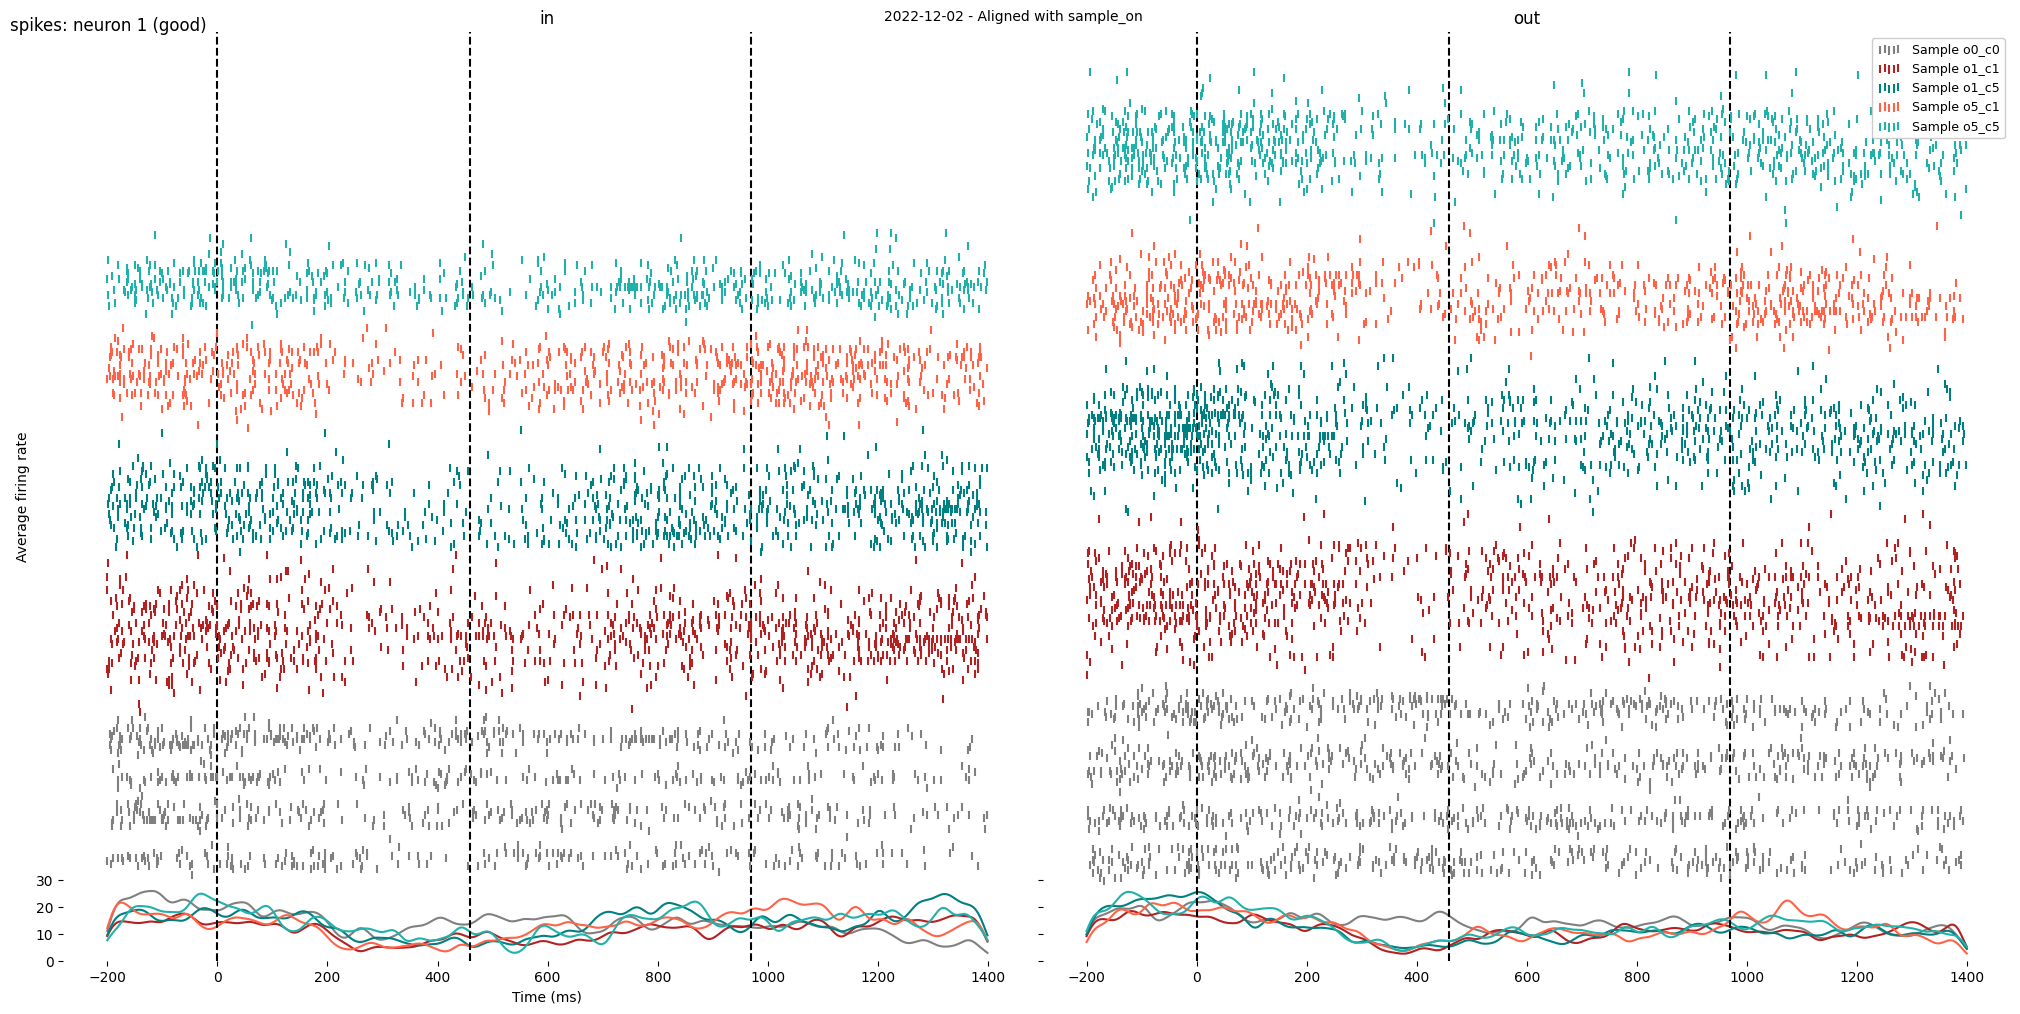

In [7]:
i_neuron = 0
t_before = 200
neuron_sp = trials_sp[:, neurons[i_neuron], :]
shift_sp = SpikeData.indep_roll(neuron_sp, -(trials_s_on - t_before).astype(int), axis=1)[:, :1600]
# Iterate by sample and condition
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
ax2 = [ax[0].twinx(), ax[1].twinx()]
all_max_conv = 0
all_max_trial = 0
for i_ax, cond in enumerate(["in", "out"]):
    count_trials =  0
    max_conv = 0
    for i_s, i_sample in enumerate(samples):
        sample_idx = task[
            np.logical_and(task["i_neuron"] == i_neuron,np.logical_and(task["in_out"] == cond, task["sample"] == i_sample))
        ]["trial_idx"].values
        # Select trials with at least 2 spikes/sec 
        bool_shift_sp = np.sum(shift_sp[sample_idx],axis=1)>=np.floor(2 * (shift_sp[sample_idx].shape[1]/1000))
        mean_sp = np.zeros(shift_sp.shape[1])
        if np.sum(bool_shift_sp)>3:
            mean_sp = shift_sp[sample_idx][bool_shift_sp].mean(axis=0)
        conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        max_conv = np.max(conv) if np.max(conv) > max_conv else max_conv
        time = np.arange(0,len(conv))-t_before
        ax[i_ax].plot( time,
            conv,
            color=task_constants.PALETTE_B1[i_sample],
        )
        # Plot spikes
        count_t = len(sample_idx)
        rows,cols = np.where(shift_sp[sample_idx]>=1)
        ax2[i_ax].scatter(cols-t_before,rows+count_trials, marker='|', alpha=1,edgecolors='none',color=task_constants.PALETTE_B1[i_sample],label="Sample %s" % i_sample)
        count_trials +=count_t
    all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
    all_max_trial = count_trials if count_trials > all_max_trial else all_max_trial
    ax[i_ax].set_title(cond)
for i_ax in range(2):
    ax[i_ax].set_ylim(0,all_max_conv+all_max_trial+5)
    ax[i_ax].set_yticks(np.arange(0, all_max_conv+5,10))
    ax2[i_ax].set_yticks(np.arange(-all_max_conv-5, all_max_trial))
    plt.setp(ax2[i_ax].get_yticklabels(), visible=False)
    plt.setp(ax2[i_ax].get_yaxis(), visible=False)
    ax[i_ax].vlines(
            [0,mean_s_off,mean_t_on_1],
            0,
            all_max_conv+all_max_trial+5,
            color='k',
            linestyles="dashed",
        )
    ax2[i_ax].spines["right"].set_visible(False)
    ax2[i_ax].spines["left"].set_visible(False)
    ax2[i_ax].spines["top"].set_visible(False)
    ax2[i_ax].spines["bottom"].set_visible(False)
    ax[i_ax].spines["right"].set_visible(False)
    ax[i_ax].spines["left"].set_visible(False)
    ax[i_ax].spines["top"].set_visible(False)
    ax[i_ax].spines["bottom"].set_visible(False)
ax[0].set(xlabel="Time (ms)", ylabel="Average firing rate")
ax2[1].set(xlabel="Time (ms)", ylabel="trials")
ax2[1].legend(fontsize=9,scatterpoints=5,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')

# fig.legend()
fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
fig.text(
    0.5,
    0.99,
    s="%s - Aligned with %s"
    % (s_path[-1][:-4][:10], list(task_constants.EVENTS_B1.keys())[2]),
    horizontalalignment="center",
    verticalalignment="center",
)
ss_path = s_path[-1][:-3]
fig.suptitle("%s: neuron %d (%s)  " % (s_path[-2], i_neuron + 1, cgroup), x=0.05, y=0.99)
#fig.savefig(ss_path + "_" + cgroup + "_" + str(i_neuron + 1) +'.svg', bbox_inches="tight",transparent=True)
#fig.savefig(ss_path + "_" + cgroup + "_" + str(i_neuron + 1) +'.pdf', bbox_inches="tight",transparent=True)

#### Check sample selectiviy


## Stats

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
from sklearn.multiclass import OneVsRestClassifier
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
seed = 2023

In [9]:
n_neuron = 8

## SVM

#### def functions

In [10]:
def run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value):
    scores = np.zeros((n_iterations,steps))
    for n_it in np.arange(n_iterations):
        #  select trials randomly
        df = []
        for i_df in list_df:
            df.append(i_df.sample(resample_value,random_state=it_seed[n_it],replace=False)) # sample without replacement
        df = pd.concat(df).reset_index(drop=True)
        
        #df = df.sample(frac=1,random_state=it_seed[n_it],replace=False)
        
        X = df.iloc[:, :-4] 
        #X = pd.DataFrame(scaler.fit_transform(X))
        y = df['label_encoder']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
        X_train['label_encoder'] = y_train
        #X_test['label_encoder'] = y_test
        # Sample with replacement
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=False)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        for n,n_win in enumerate(np.arange(0,steps*win_steps,win_steps)):
            # Split into X and y
            scaler = MinMaxScaler()
            X = X_train.iloc[:,int(n_win):int(n_win)+win_size].mean(axis=1).values.reshape(-1, 1)
            X = pd.DataFrame(scaler.fit_transform(X))    
            # test
            X_t = X_test.iloc[:,int(n_win):int(n_win)+win_size].mean(axis=1).values.reshape(-1, 1)        
            X_t = pd.DataFrame(scaler.transform(X_t))
            model.fit(X,y_train)
            y_predict = model.predict(X_t)
            scores[n_it, n] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [11]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

#### Model

In [12]:
# define model
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)
# data preparation
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
n_iterations = 10
win_steps = 10
win_size = 100
steps = int(np.ceil((len(neuron_fr.columns[:-4])/win_steps)))
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)

NameError: name 'fr_samples' is not defined

In [ ]:
# encode labels
le = LabelEncoder()
le.fit(neuron_fr['sample'].replace(['B','C','D'],'A').values)
neuron_fr['label_encoder'] = le.transform(neuron_fr.loc[:,'sample'].replace(['B','C','D'],'A').values) # encode labels
# Resample dataframe
resample_value = neuron_fr[neuron_fr['sample']=='N']['sample'].value_counts().min()
list_df=[neuron_fr[(neuron_fr['sample'] == 'A') | (neuron_fr['sample'] == 'B') | (neuron_fr['sample'] == 'C') | (neuron_fr['sample'] == 'D')],neuron_fr[neuron_fr['sample'] == 'N']]

In [ ]:
scores = run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value)
plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron)

#### Predict samples

In [ ]:
# encode labels
le = LabelEncoder()
le.fit(neuron_fr['sample'].values)
neuron_fr['label_encoder'] = le.transform(neuron_fr['sample'].values) # encode labels
# Resample dataframe
resample_value = neuron_fr['sample'].value_counts().min()
list_df=[neuron_fr[neuron_fr['sample'] == 'A'],neuron_fr[neuron_fr['sample'] == 'B'],neuron_fr[neuron_fr['sample'] == 'C'],neuron_fr[neuron_fr['sample'] == 'D'],neuron_fr[neuron_fr['sample'] == 'N']]

In [ ]:
scores_samples = run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value)
plot_accuracy(scores_samples,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron)

## ANOVA

#### def functions

In [ ]:
def select_from_df(df1,samples,n_neuron,df2=np.nan):
    if isinstance(df2,pd.DataFrame) == False:
        df2=df1
    # add to check shapes of df1 == df2
    sample_df = []
    for s in samples:
        sample_df.append(df1[(df2['sample']==s)&(df2['neuron']==n_neuron)])
    return pd.concat(sample_df,axis=0)

In [ ]:
# t_test
def compute_f_oneway(group1,group2,group3,group4,neuron_max_shift,seed):
    foneway:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        trials_group3 = group3.iloc[:,n_win]
        trials_group4 = group4.iloc[:,n_win]
        #trials_group5 = group5.iloc[:,n_win]
        p=stats.f_oneway(trials_group1.values, trials_group2.values,trials_group3.values, trials_group4.values)#,trials_group5.values)
        foneway['p']+=[p[1]]
        
    foneway=pd.DataFrame(foneway)
    fig,ax=plt.subplots(figsize=(10,3))
    bonferroni_foneway = multipletests(foneway.values.reshape(-1),alpha=0.05)[1]
    mask_b = bonferroni_foneway<0.05
    mask_f = foneway.values.reshape(-1)<0.05
    ax.plot((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000,foneway.values.reshape(-1))
    ax.scatter(((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000)[mask_f],foneway.values.reshape(-1)[mask_f],c='b',marker='.')
    ax.plot((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000,bonferroni_foneway)
    ax.scatter(((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000)[mask_b],bonferroni_foneway[mask_b],c='firebrick',marker='.')

    return foneway

#### compute anova

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 500
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()

In [ ]:
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
#n = select_from_df(df1=mean_fr_window,samples=['N'],n_neuron=n_neuron,df2=neuron_fr)
foneway = compute_f_oneway(a,b,c,d,neuron_max_shift,seed)


## t test

#### def functions

In [ ]:
# t_test
def compute_t_test(group1,group2,neuron_max_shift,seed):
    t_test:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        p=stats.ttest_ind(trials_group1.values, trials_group2.values)
        t_test['p']+=[p[1]]
        
    t_test=pd.DataFrame(t_test)
    fig,ax=plt.subplots(figsize=(10,3))
    bonferroni_t_test = multipletests(t_test.values.reshape(-1),alpha=0.05)[1]
    mask_b = bonferroni_t_test<0.05
    mask_t = t_test.values.reshape(-1)<0.05
    ax.plot((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000,t_test.values.reshape(-1))
    ax.scatter(((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000)[mask_t],t_test.values.reshape(-1)[mask_t],c='b',marker='.')
    ax.plot((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000,bonferroni_t_test)
    ax.scatter(((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000)[mask_b],bonferroni_t_test[mask_b],c='firebrick',marker='.')
    ax.set(xlabel="Time (s)", ylabel="p-value")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['t-test','values under 0.05','bonferroni','values under 0.05'], fontsize=8)
    return t_test


#### compute t-test

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 500
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()

In [ ]:
# test whether the neuron is engaged in the task (N vs others)
all_sample_presentation = select_from_df(df1=mean_fr_window,samples=['A','B','C','D'],n_neuron=n_neuron,df2=neuron_fr)
n_sample_presentation = select_from_df(df1=mean_fr_window,samples=['N'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(all_sample_presentation,n_sample_presentation,neuron_max_shift,seed)

#### Check if it is sample selective
The neuron is sample selective only if it is significant for one of the following (a vs d | b vs c):

In [ ]:
# Color - orientation 1
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,d,neuron_max_shift,seed)

In [ ]:
# Color - orientation 2 
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(b,c,neuron_max_shift,seed)

In [ ]:
# Orientation 
ab = select_from_df(df1=mean_fr_window,samples=['A','B'],n_neuron=n_neuron,df2=neuron_fr)
cd = select_from_df(df1=mean_fr_window,samples=['C','D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(ab,cd,neuron_max_shift,seed)

In [ ]:
# Color
ac = select_from_df(df1=mean_fr_window,samples=['A','C'],n_neuron=n_neuron,df2=neuron_fr)
bd = select_from_df(df1=mean_fr_window,samples=['B','D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(ac,bd,neuron_max_shift,seed)

In [ ]:
# A vs C (same color)
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,c,neuron_max_shift,seed)

In [ ]:
# A vs B (same orientation)
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,b,neuron_max_shift,seed)

In [ ]:
# C vs D (same orientation)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,c,neuron_max_shift,seed)

## index

#### Def functions

In [ ]:
# index
def compute_index(group1,group2,neuron_max_shift,seed):
    index:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        if trials_group1.mean!=0 or trials_group2.mean()!=0:
            if trials_group1.mean()>trials_group2.mean():
                pref = trials_group1
                n_pref = trials_group2
                g=0
            else:
                pref = trials_group2
                n_pref = trials_group1 
                g=1
            index['idx']+=[(pref.mean()-n_pref.mean())/(pref.mean()+n_pref.mean())]#np.sqrt((pref.var()+n_pref.var())/2)
            index['group'] += [g]
        else:
            index['idx']+=[0]
            index['group'] += [0.5]
        
    index=pd.DataFrame(index)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot((np.arange(len(index))-neuron_max_shift[0]/step)/1000,index['idx'].values.reshape(-1))
    ax.plot((np.arange(len(index))-neuron_max_shift[0]/step)/1000,index['group'].values.reshape(-1))    
    return index

#### Compute index

In [ ]:
index=compute_index(a,d,neuron_max_shift,seed)

## ROC AUC score

#### Def functions

In [ ]:
def compute_roc_auc(group1,group2):
    roc_score:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
    for n_win in np.arange(a.shape[1]):
        g1 = group1.iloc[:,n_win]
        g2 = group2.iloc[:,n_win]
        min_fr, max_fr = pd.concat((g1,g2)).min(),pd.concat((g1,g2)).max()
        thresholds = np.arange(min_fr,max_fr+0.01,0.01)
        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1.values>=threshold,g2.values>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            idx_sort=fpr.argsort()
            score = metrics.auc(fpr[idx_sort],tpr[idx_sort])
            roc_score['score']+=[score]
        else:
            roc_score['score']+=[0.5]
    roc_score=pd.DataFrame(roc_score)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot((np.arange(len(roc_score))-neuron_max_shift[0]/step)/1000,roc_score['score'].values.reshape(-1))   
    ax.set(xlabel="Time (s)", ylabel="ROC AUC score")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    
    return roc_score


#### Compute roc

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 100
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
roc_score =compute_roc_auc(a,d)

In [ ]:
ac = select_from_df(df1=mean_fr_window,samples=['A','C'],n_neuron=n_neuron,df2=neuron_fr)
bd = select_from_df(df1=mean_fr_window,samples=['B','D'],n_neuron=n_neuron,df2=neuron_fr)
roc_score = compute_roc_auc(ac,bd)